### Classification of Esophagitis, Polyps, and Ulcerative Colitis

##### As an AI/ML scientist, you're tasked with building a model that can classify three types of pathological findings in endoscopic images to help doctors identify conditions early and improve patient outcomes. These findings include Esophagitis, Polyps, and Ulcerative Colitis.

In [28]:
# import libraries

import tensorflow
from tensorflow.keras.layers import Conv2D,Flatten,Dense,MaxPool2D,BatchNormalization,GlobalAveragePooling2D,Dropout
from tensorflow.keras.applications.resnet50 import preprocess_input,decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model, load_model
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import cv2
import os
from tensorflow.keras.metrics import Precision, Recall, AUC  # Import the metrics here


In [2]:
import os
import shutil
import random

# Define source directory and destination directories
source_dir = '/kaggle/input/kvasir'  # Directory containing all disease subdirectories
train_dir = 'train'
test_dir = 'test'
split_ratio = 0.8  # 80% train, 20% test

# Create train and test directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Loop through each subdirectory (i.e., each disease category)
for disease in os.listdir(source_dir):
    disease_path = os.path.join(source_dir, disease)
    
    if os.path.isdir(disease_path):  # Ensure it's a directory
        # Create corresponding subdirectories in train and test
        os.makedirs(os.path.join(train_dir, disease), exist_ok=True)
        os.makedirs(os.path.join(test_dir, disease), exist_ok=True)

        # Get all the image filenames in the disease directory
        images = os.listdir(disease_path)
        random.shuffle(images)  # Shuffle images for random splitting

        # Calculate the split index
        split_index = int(len(images) * split_ratio)

        # Split the images into train and test
        train_images = images[:split_index]
        test_images = images[split_index:]

        # Copy the train images to the train directory
        for image in train_images:
            source_image_path = os.path.join(disease_path, image)
            target_train_path = os.path.join(train_dir, disease, image)
            shutil.copyfile(source_image_path, target_train_path)

        # Copy the test images to the test directory
        for image in test_images:
            source_image_path = os.path.join(disease_path, image)
            target_test_path = os.path.join(test_dir, disease, image)
            shutil.copyfile(source_image_path, target_test_path)

        print(f"Copied {len(train_images)} images to {os.path.join(train_dir, disease)}")
        print(f"Copied {len(test_images)} images to {os.path.join(test_dir, disease)}")


Copied 400 images to train/polyps
Copied 100 images to test/polyps
Copied 400 images to train/ulcerative-colitis
Copied 100 images to test/ulcerative-colitis
Copied 400 images to train/esophagitis
Copied 100 images to test/esophagitis


In [5]:
# Define image size and batch size
IMG_SIZE = 224
BATCH_SIZE = 32

# Define paths for training and test directories
train_dir = 'train'
test_dir = 'test'

In [6]:
# Create ImageDataGenerator for training with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [7]:
# Create ImageDataGenerator for testing without augmentation, only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
# Load the training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 1200 images belonging to 3 classes.


In [10]:


# Load the test data
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Load the ResNet50 model pre-trained on ImageNet, excluding the top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))


Found 300 images belonging to 3 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [39]:

# Add custom layers on top of the ResNet50 base
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Adding more custom layers
x = Dense(2048, activation='relu')(x)
x = Dropout(0.2)(x)  # Dropout layer for regularization
x = Dense(1024, activation='relu')(x)  # Another dense layer
x = Dense(512, activation='relu')(x) # Another dense layer

predictions = Dense(3, activation='softmax')(x)  # 3 classes: Esophagitis, Polyps, Ulcerative Colitis


# Define the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of ResNet50 to prevent training
for layer in base_model.layers:
    layer.trainable = True

In [40]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',Precision(), Recall(), AUC()])

In [41]:
# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator
)

Epoch 1/10


I0000 00:00:1729330552.894398     138 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_25', 60 bytes spill stores, 60 bytes spill loads



38/38 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.6520 - auc_3: 0.7891 - loss: 1.5062 - precision_3: 0.6734 - recall_3: 0.5575 - val_accuracy: 0.3333 - val_auc_3: 0.5000 - val_loss: 574001.2500 - val_precision_3: 0.3333 - val_recall_3: 0.3333
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 87s 632ms/step - accuracy: 0.8756 - auc_3: 0.9695 - loss: 0.3459 - precision_3: 0.8957 - recall_3: 0.8362 - val_accuracy: 0.3333 - val_auc_3: 0.5000 - val_loss: 2235.1653 - val_precision_3: 0.3333 - val_recall_3: 0.3333
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 624ms/step - accuracy: 0.9093 - auc_3: 0.9788 - loss: 0.2724 - precision_3: 0.9136 - recall_3: 0.9037 - val_accuracy: 0.3333 - val_auc_3: 0.6361 - val_loss: 1.4848 - val_precision_3: 0.3333 - val_recall_3: 0.3333
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 635ms/step - accuracy: 0.9203 - auc_3: 0.9874 - loss: 0.2022 - precision_3: 0.9252 - recall_3: 0.9151 - val_accuracy: 0.3333 - val_auc_3: 0.5838 - val_loss: 1.2163 - val_precision_3: 0.5170 - val_re

In [42]:
# Evaluate the model on test data
test_loss, test_accuracy, test_precision, test_recall, test_auc = model.evaluate(test_generator)

# Print test evaluation metrics
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test AUC: {test_auc}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 244ms/step - accuracy: 0.3179 - auc_3: 0.5826 - loss: 2.9127 - precision_3: 0.3179 - recall_3: 0.3179
Test Loss: 2.845364570617676
Test Accuracy: 0.3333333432674408
Test Precision: 0.3333333432674408
Test Recall: 0.3333333432674408
Test AUC: 0.5986055731773376


In [43]:
# Save the model
model.save('resnet50_esophagitis_polyps_ulcerative_colitis.h5')

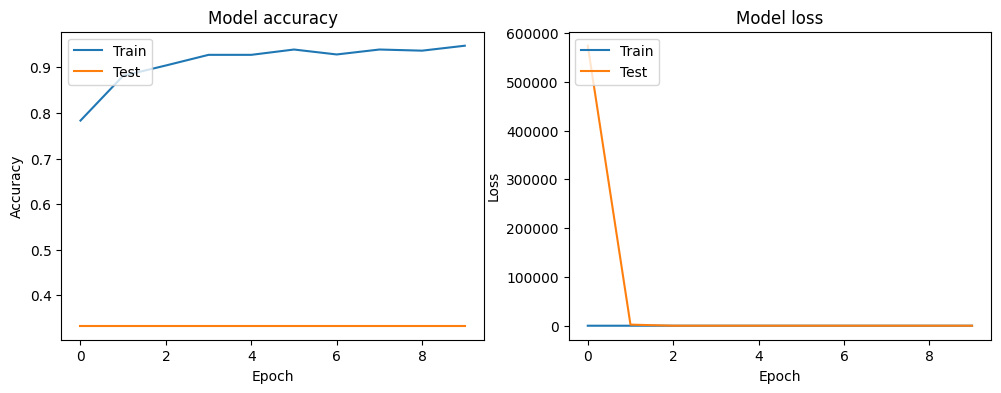

In [44]:
import matplotlib.pyplot as plt


# Plot accuracy and loss curves
def plot_metrics(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    plt.show()

# Call the function to plot
plot_metrics(history)


In [53]:
import numpy as np
from tensorflow.keras.preprocessing import image

def predict_image_class(img_path, model):
    # Load the image
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale like during training

    # Predict the class
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)
    
    # Class mapping (assuming Esophagitis: 0, Polyps: 1, Ulcerative Colitis: 2)
    classes = ['Esophagitis', 'Polyps', 'Ulcerative Colitis']
    print(f"Predicted class: {classes[predicted_class[0]]}")
    return classes[predicted_class[0]]

In [67]:
#loaded_model = /kaggle/working/resnet50_esophagitis_polyps_ulcerative_colitis.h5
# Example usage:
predict_image_class('/kaggle/working/test/esophagitis/01a57b1a-780f-4e52-9f94-291c2982154d.jpg',model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted class: Esophagitis


'Esophagitis'

#### Detecting Overfitting
##### Monitor Loss: 
Track training and validation loss. Overfitting is indicated by a decreasing training loss and increasing validation loss.

##### Evaluate Metrics: 
Compare metrics (accuracy, precision, recall, AUC) for training and validation sets. A large discrepancy suggests overfitting.

#### Handling Overfitting
###### Data Augmentation: 
Use techniques like rotation, shifting, and flipping to create more diverse training data.
###### Dropout: 
Add dropout layers to randomly deactivate neurons during training.
L2 Regularization: Apply L2 regularization to the Dense layers to penalize large weights.

###### Early Stopping: 
Use early stopping to halt training when validation loss starts to increase.
##### Reduce Model Complexity: 
Simplify the model architecture to prevent overfitting.